In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

1.Defining the  the CardGame Class

In [2]:

class CardGame:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.dealer_card = np.random.randint(1, 14)  # Dealer's card (1-13)
        self.player_sum = np.random.randint(1, 14)  # Player's initial card
        return (self.dealer_card, self.player_sum)
    
    def draw_card(self):
        value = np.random.randint(1, 14)  # Draw card (1-13)
        color = np.random.choice(['red', 'black'], p=[1/3, 2/3])
        return value, color
    
    def step(self, state, action):
        dealer_card, player_sum = state
        
        if action == 'hit':
            value, color = self.draw_card()
            if color == 'black':
                player_sum += value
            else:
                player_sum -= value
            
            if player_sum > 21 or player_sum < 1:
                return (dealer_card, player_sum), -1  # Player goes bust, end of episode
            
            return (dealer_card, player_sum), 0  # Continue game
        
        elif action == 'stick':
            # Play out dealer's turn
            dealer_sum = dealer_card
            while dealer_sum < 17:
                value, color = self.draw_card()
                if color == 'black':
                    dealer_sum += value
                else:
                    dealer_sum -= value
            
            # Determine outcome
            if dealer_sum > 21:
                return (dealer_card, player_sum), 1  # Dealer goes bust, player wins
            elif player_sum > dealer_sum:
                return (dealer_card, player_sum), 1  # Player wins
            elif player_sum < dealer_sum:
                return (dealer_card, player_sum), -1  # Dealer wins
            else:
                return (dealer_card, player_sum), 0  # Draw

2. Implement Monte Carlo Control
Initialize the value function to zero. Use a time-varying scalar step-size
of αt = 1
N(st ,at ) and an ϵ-greedy exploration strategy with ϵt = N0
N0+N(st ) , where N0 = 100 is a constant, N(s) is the
number of times that state s has been visited, and N(s, a) is the number of times that action a has been selected
from state s.


In [3]:

#find optimal policy by learning from complete episodes,bu finding optimal action value function
def monte_carlo_control(num_episodes):
    N0 = 100  # Constant for epsilon calculation
    Q = {}  # Dictionary to store action-value function Q(s, a)
    N = {}  # Dictionary to store number of visits to state-action pairs
    actions = ['hit', 'stick']
    game = CardGame()

    for episode in range(1, num_episodes + 1):
        states_visited = []
        actions_taken = []
        rewards = []

        state = game.reset()
        done = False

        while not done:
            dealer_card, player_sum = state

            # Calculate epsilon using N0 and number of times state has been visited
            if state in N:
                epsilon = N0 / (N0 + sum(N[state].values()))
            else:
                epsilon = 1.0  # Fully explore if state has not been visited

            # Epsilon-greedy policy
            if state in Q and np.random.uniform() < epsilon:
                action = np.random.choice(list(Q[state].keys())) #explotayio
            else:
                action = np.random.choice(actions)

            next_state, reward = game.step(state, action)
            states_visited.append(state)
            actions_taken.append(action)
            rewards.append(reward)

            if state not in Q:
                Q[state] = {}
                N[state] = {}

            if action not in Q[state]:
                Q[state][action] = 0
                N[state][action] = 0

            N[state][action] += 1

            if reward != 0:
                done = True
            state = next_state

        # Update Q-values after the episode
        #everything latest
        G = 0
        for t in reversed(range(len(states_visited))):
            state = states_visited[t]
            action = actions_taken[t]
            G = rewards[t]
            alpha = 1 / N[state][action]
            Q[state][action] += alpha * (G - Q[state][action])
            #computing q value for that particular state action pair

    return Q

 3.Compute and Plot the Optimal Value Function
 Plot the optimal
value function V *(s) = maxa Q*(s, a) using similar axes

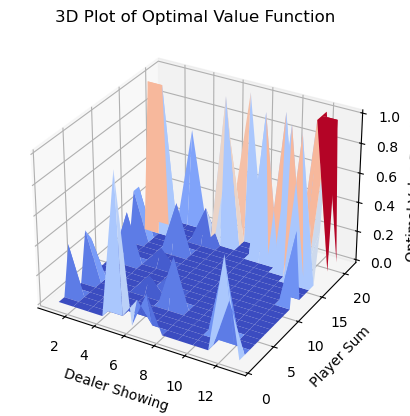

In [4]:

# Run Monte Carlo control algorithm
num_episodes = 15000
monte_carlo_qvalues = monte_carlo_control(num_episodes)

# Initialize arrays to store max Q-values and true Q-values
max_q_values = np.zeros((21, 13, 2))  # Dimensions: player's sum (1-21), dealer's showing card (1-13), action (hit or stick)
true_q_values = np.zeros((21, 13, 2))  # Dimensions: player's sum (1-21), dealer's showing card (1-13), action (hit or stick)

# Extract and store Q-values
for state, actions in monte_carlo_qvalues.items():
    dealer_card, player_sum = state
    for action, value in actions.items():
        action_index = 0 if action == 'hit' else 1
        max_q_values[player_sum - 1, dealer_card - 1, action_index] = max(max_q_values[player_sum - 1, dealer_card - 1, action_index], value)
        true_q_values[player_sum - 1, dealer_card - 1, action_index] = value
    #indices satrt from 0 so 01 used
# Compute the optimal state-value function V*
V_star = np.max(max_q_values, axis=2)
# By specifying axis=2, the np.max function computes the maximum Q-value for each state across the two possible actions ('hit' and 'stick').
# Assuming you have already run the Monte Carlo control and computed V_star

# Create a 3D plot of the optimal value function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(1, 14), range(1, 22))  # Adjust the ranges to match dealer's card and player's sum
surf = ax.plot_surface(X, Y, V_star, cmap=cm.coolwarm)
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
ax.set_zlabel('Optimal Value Function')
ax.set_title('3D Plot of Optimal Value Function')
plt.show()


In [5]:

def sarsa_lambda(num_episodes, lambda_val):
    N0 = 100  # Constant for epsilon calculation
    alpha = 0.1  # Step size
    Q = {}  # Dictionary to store action-value function Q(s, a)
    N = {}  # Dictionary to store number of visits to state-action pairs
    actions = ['hit', 'stick']
    game = CardGame()
    
    for episode in range(1, num_episodes + 1):
        state = game.reset()
        action = np.random.choice(actions)  # Randomly select initial action
        
        # Initialize Q-values for the state-action pairs
        if state not in Q:
            Q[state] = {a: 0 for a in actions}
            # It ensures that every state-action pair has a Q-value, even if it's just initialized to zero.
        
        done = False
        episode_trace = []
        
        while not done:
            next_state, reward = game.step(state, action)
            
            # Epsilon-greedy policy
            if state not in N:
                N[state] = {a: 0 for a in actions}
            epsilon = N0 / (N0 + sum(N[state].values()))
            if np.random.uniform() < epsilon:
                next_action = np.random.choice(actions)
            else:
                if next_state in Q:
                    next_action = max(Q[next_state], key=Q[next_state].get)#greedy
                else:
                    next_action = np.random.choice(actions)
            
            # Store the transition
            episode_trace.append((state, action, reward))#Append the current state, action, and reward to episode_trace for later use.

            
            if next_state not in Q:
                Q[next_state] = {a: 0 for a in actions}
            
            if reward != 0:
                done = True
            
            state = next_state
            action = next_action
        
        # Forward view: Update Q-values at the end of the episode
        G = 0
        for t in reversed(range(len(episode_trace))):
            state, action, reward = episode_trace[t]
            G = lambda_val * G + reward
            if state in N and action in N[state]:
                N[state][action] += 1
                alpha = 1 / N[state][action]
            else:
                alpha = 0.1
            
            Q[state][action] += alpha * (G - Q[state][action])
    
    return Q

5.Defining the mean squared error ,plot results and plot results as a function.

In [6]:

def compute_mse(Q_estimated, Q_true):
    mse = 0
    for state, actions in Q_true.items():
        for action, true_value in actions.items():
            if state in Q_estimated and action in Q_estimated[state]:
                estimated_value = Q_estimated[state][action]
                mse += (estimated_value - true_value) ** 2
    mse /= len(Q_true) * 2  # Number of state-action pairs
    return mse


def plot_results(lambdas, mean_squared_errors):
    plt.figure(figsize=(10, 5))
    plt.plot(lambdas, mean_squared_errors, marker='o')
    plt.xlabel('λ (Lambda)')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs λ')
    plt.grid(True)
    plt.show()

def plot_learning_curve(learning_curves):
    plt.figure(figsize=(10, 5))
    for lambda_val, errors in learning_curves.items():
        plt.plot(range(1, len(errors) + 1), errors, label=f'λ = {lambda_val}')
    plt.xlabel('Episode')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve for λ = 0 and λ = 1')
    plt.legend()
    plt.grid(True)
    plt.show()


6.Plotting the mean-squared error against λ. For λ = 0 and λ = 1 onlyand  plotting the learning curve of mean-squared error
against episode number.

Time taken for SARSA(λ) computation: 149.01103901863098 seconds


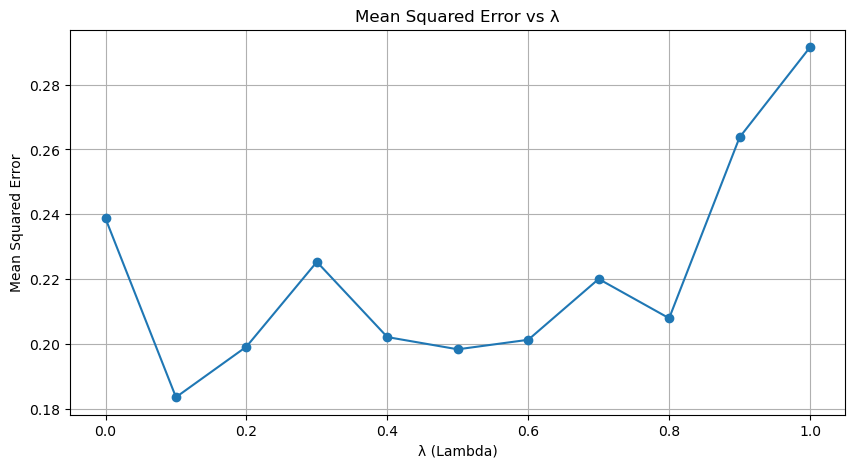

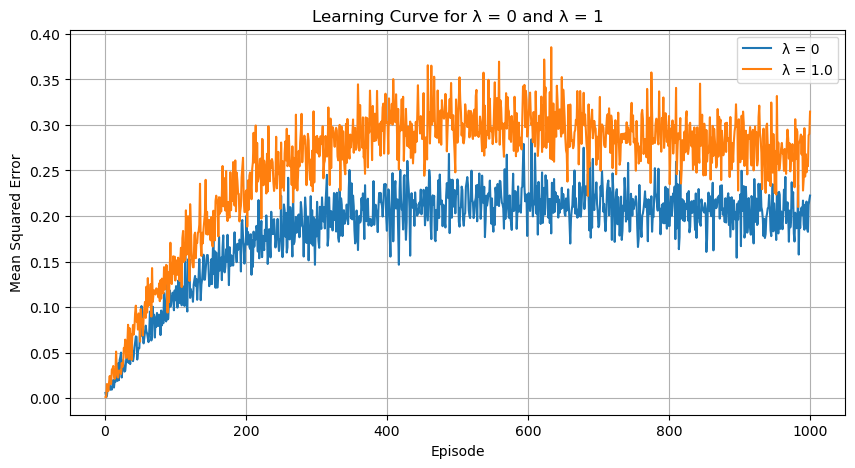

In [7]:


# Define parameters
num_episodes = 1000
lambdas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
learning_lambdas = [0, 1.0]  # Only plot learning curves for λ = 0 and λ = 1
start_time = time.time()

# Store mean squared errors for each λ
mean_squared_errors = []
learning_curves = {lambda_val: [] for lambda_val in learning_lambdas}

for lambda_val in lambdas:
    Q = sarsa_lambda(num_episodes, lambda_val)

    # Calculate mean squared error
    mse = compute_mse(Q, monte_carlo_qvalues)
    mean_squared_errors.append(mse)

    # Record learning curves for specific λ values
    if lambda_val in learning_lambdas:
        learning_curves[lambda_val] = [compute_mse(sarsa_lambda(episode, lambda_val), monte_carlo_qvalues) for episode in range(1, num_episodes + 1)]

end_time = time.time()
print(f"Time taken for SARSA(λ) computation: {end_time - start_time} seconds")

# Plot results
plot_results(lambdas, mean_squared_errors)
plot_learning_curve(learning_curves)
